In [1]:
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import os

In [4]:
#adding another frequency
f1 = 10
f2 = 80

sampling_rate = 2000 #samples per second
total_time = 50 #seconds
sampling_points = total_time*sampling_rate

time = np.linspace(0,total_time,sampling_points)#e.g. [0.0,0.1 ...10.0]

sinus = np.sin(f1*time*2*np.pi)#normal sin wave: 1/2PI Hertz. Hence *2PI to have 1 Hz
sinus += np.sin(f2*time*2*np.pi)#normal sin wave: 1/2PI Hertz. Hence *2PI to have 1 Hz

In [5]:
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

In [6]:
x = sinus#overwrite
fs = sampling_rate

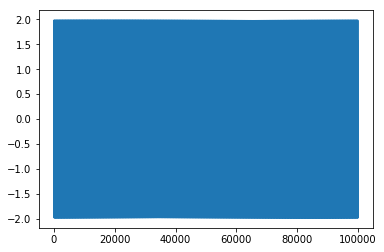

In [7]:
plt.plot(x)

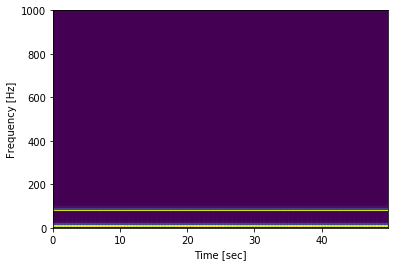

In [8]:
f, t, Sxx = signal.spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [9]:
fourier = np.fft.fft(np.copy(x))#2. COMPUTE FFT


In [10]:
fourier.real.shape

(100000,)

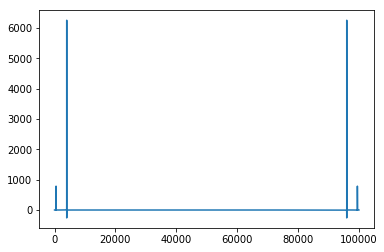

In [11]:
plt.plot(fourier.real)


In [12]:
low = 13#Low Pass
modified_1 = np.copy(fourier)
modified_1[low:-low] = 0

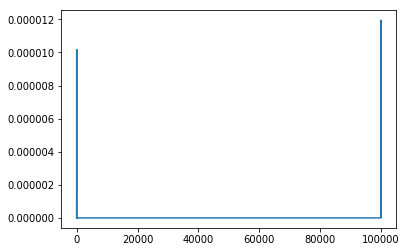

In [13]:
plt.plot(modified_1.real)


In [14]:
reconstructed = np.fft.ifft(modified_1).real

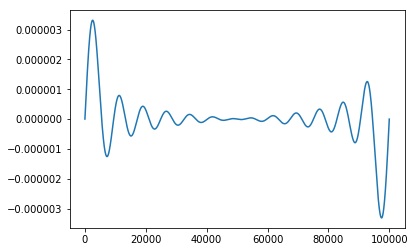

In [15]:
plt.plot(reconstructed)

In [16]:
high = 50
modified_2 = np.copy(fourier)
for x in range(high):
    modified_2[x] =  0#set high frequencies above low to 0 (mirror reversed)
    modified_2[-x] =  0#set high frequencies above low to 0 (mirror reversed)

In [17]:
reconstructed = np.fft.ifft(modified_2).real

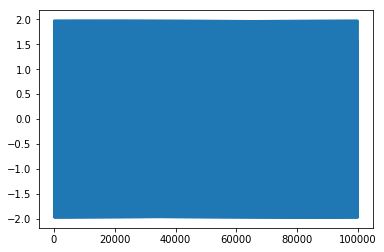

In [18]:
plt.plot(reconstructed)

In [19]:
def bandpass(x, lower_bound=None,upper_bound=None, exclusive = True):
    #Digital bandpass
    if exclusive:
        if(lower_bound):
            lower_bound = lower_bound -1
        if(upper_bound):
            upper_bound = upper_bound +1
    fourier = np.fft.fft(np.copy(x))
    modified = np.copy(fourier)

    if(lower_bound):
        modified[lower_bound:-lower_bound] = 0
    if(upper_bound):
        modified[-upper_bound:upper_bound] = 0
        
    
    return np.fft.ifft(modified).real

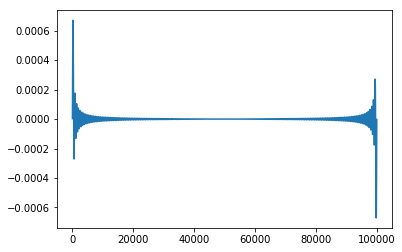

In [20]:
plt.plot(bandpass(sinus,lower_bound=180,upper_bound = 300))

# Spectrogram via fourier analyssis

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import json

In [32]:
path = "/mnt/c/Users/eler/Documents/Cognitive_Science/Bachelorarbeit/Scripts/processing_pipeline/dyad_13/DualEEG_RPS_C_13.eeg"

In [33]:
def load_eeg(filepath, channel):
    """ Loads eeg file, emits channeldata and channel_signal"""

    n_channels = 64
    bytes_per_sample = 2 #Because int16

    my_type = np.dtype([("channel"+str(x),np.int16) for x in range(0,n_channels)])
    byte_size = os.path.getsize(filepath)

    nFrames =  byte_size // (bytes_per_sample * n_channels);
    data = np.array(np.fromfile(filepath,dtype=my_type))["channel"+str(channel)]

    data = np.array(data, dtype= np.float32)
    data[data==32767] = np.nan
    data[data==-32768] = np.nan
    data[data==-32767] = np.nan

    return data

In [34]:
def spectrogram(eeg, f_max =100, f_min = 0, window_size =2000,step_size = 20):
    output_size = (len(eeg)//step_size,f_max)
    power = np.zeros(output_size)

    for i in range(len(power)):
        snippet = eeg[step_size*i-window_size//2:step_size*i+window_size//2]
        if not len(snippet == window_size):
            continue
        val = np.fft.fft(snippet).real[:f_max]
        power[i] = val

        if i % 2000 == 0:
            print(".", end ="")
    return power.T[f_min:]

In [35]:
import re
def parse_vmrk(path):
    """ Parses vmrk file and returns a dictionary containing the information.
        The keys denote the kind of data whereas the values are a dictionary
    """

    with open(path) as f:
        content = f.readlines()

    data = {'marker number':[], 'type':[], 'description':[], 'time':[], 'size':[], 'channel':[]}

    entry = 0
    for line in content:
        match = re.match("Mk", line)
        if(match != None):
            markers = re.search("[0-9][0-9]?", line)
            data["marker number"].append(int(markers.group(0)))
            line = line[markers.end():]#use rest of line only next

            markers = re.match("(.*?),",line)
            data["type"].append(markers.group(1)[1:])#Group 1 is exclusive , while group 0 is inclusive ,
            line = line[markers.end():]

            markers = re.search("(.*?),",line)
            data["description"].append(markers.group(1))
            line = line[markers.end():]

            markers = re.search("(.*?),",line)
            data["time"].append('0' + markers.group(1))# '0' + is necessary as some fields are empty
            line = line[markers.end():]

            markers = re.search("(.*?),",line)
            data["size"].append(int('0' + markers.group(1)))
            line = line[markers.end():]

            try:#In the first line there is an additional value we dont want to parse
                data["channel"].append(int('0' + line))
            except:
                data["channel"].append(0)
    return data

In [36]:
def weighted_histograms(data, frame_range= None, n_bins = 36):
    if(360%n_bins != 0):
        raise Exception("Provide a number of bins such that 360%bins == 0 (e.g. 36, or 72)")
    bin_width = 360//n_bins
    
    if frame_range:
        data = data[frame_range[0]:frame_range[1]]
    
    outary = np.ndarray((data.shape[0],n_bins))

    for d, i in zip(data, range(data.shape[0])):
        ary = np.array([d[:,:,0].flatten(),d[:,:,1].flatten()])
        deg = np.degrees(np.arctan2(ary[0],ary[1]))#.reshape(d[0].shape[0:2])
        length = np.linalg.norm(ary, axis = 0)#.reshape(d[0].shape[0:2])
        bins = (np.arange(n_bins+1)*bin_width)-180 #start at -170. Go up in steps of 10 to 180
        weightedHist, bin_edges = np.histogram(deg, weights = length, bins = bins)
        outary[i] = weightedHist
        if i%100 == 0:
            print(i/data.shape[0])
    return outary.T

In [37]:
def weighted_histograms(data, roi = None,frame_range= None, n_bins = 36):
    if(360%n_bins != 0):
        raise Exception("Provide a number of bins such that 360%bins == 0 (e.g. 36, or 72)")
    bin_width = 360//n_bins
    
    if frame_range:
        data = data[frame_range[0]:frame_range[1]]
    
    outary = np.ndarray((data.shape[0],n_bins))
    
    current_roi = {"y1":0,"x1":0,"y2":data.shape[1],"x2":data.shape[2]}#xy xy full frame by default
    for d, i in zip(data, range(data.shape[0])):
        if(roi):
            try:#If there is info for frame update the region of interest
                roi[str(i)]
                current_roi["y1"] = roi[str(i)]["y1"]//16
                current_roi["x1"] = roi[str(i)]["x1"]//16
                current_roi["y2"] = roi[str(i)]["y2"]//16
                current_roi["x2"] = roi[str(i)]["x2"]//16
            except:
                pass
        d = d[current_roi["y1"]:current_roi["y2"],current_roi["x1"]:current_roi["x2"],:]
        ary = np.array([d[:,:,0].flatten(),d[:,:,1].flatten()])
        deg = np.degrees(np.arctan2(ary[0],ary[1]))#.reshape(d[0].shape[0:2])
        length = np.linalg.norm(ary, axis = 0)#.reshape(d[0].shape[0:2])
        bins = (np.arange(n_bins+1)*bin_width)-180 #start at -170. Go up in steps of 10 to 180
        weightedHist, bin_edges = np.histogram(deg, weights = length, bins = bins)
        outary[i] = weightedHist
        if i%100 == 0:
            print(i/data.shape[0])
    return outary.T

In [38]:
def interpolate_missing_frames(mothistmap):
    for i in range(mothistmap.shape[1]):#median
        if(np.all(mothistmap[:,i]==0)):
            print(i)
            try:
                mothistmap[:,i] = (mothistmap2[:,i-1]+mothistmap2[:,i+1])/2
            except:
                pass

In [131]:
## LOAD EEGS
spec = spectrogram(load_eeg(path, 0)-load_eeg(path, 2), f_max = 150)

.........

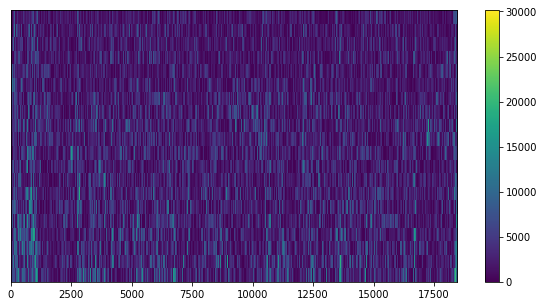

In [132]:
low = 30
high = 50
display = np.abs(spec[low:high,:])

fig, ax = plt.subplots(1,1, figsize = (10,5))

ticks = np.linspace(low,high,10)
ticklabels = [str(x+low) for x in ticks]
ax.set_yticks(np.array(ticks, dtype = "int32"))
ax.set_yticklabels(ticklabels)

img = ax.imshow(display, origin="top",aspect='auto')
plt.colorbar(img, ax = ax)

In [133]:
ticks

array([30.        , 32.22222222, 34.44444444, 36.66666667, 38.88888889,
       41.11111111, 43.33333333, 45.55555556, 47.77777778, 50.        ])

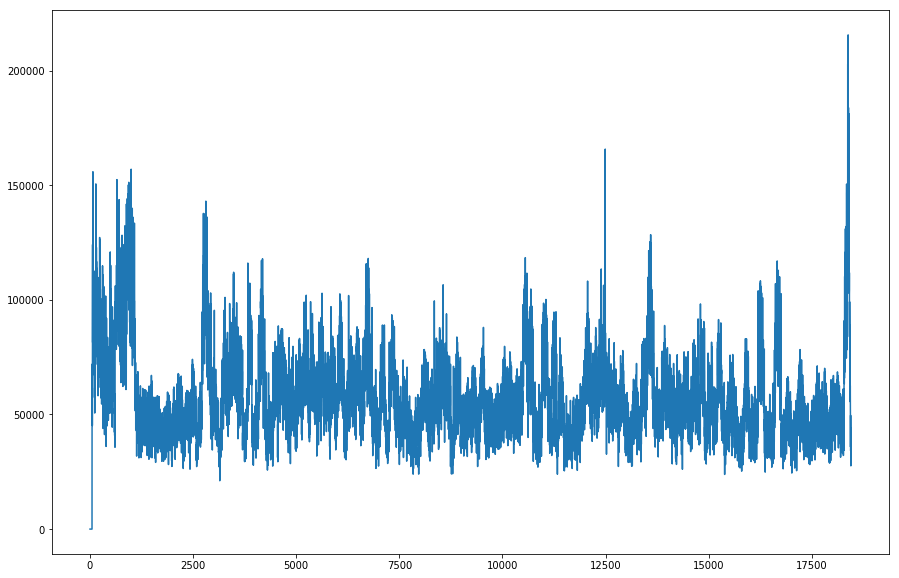

In [134]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.plot(np.sum(ndimage.gaussian_filter(display,0),axis=0))

In [135]:
# Load json describing the region of interest

folder = "/mnt/c/Users/eler/Documents/Cognitive_Science/Bachelorarbeit/Scripts/processing_pipeline/dyad_13/"

with open(folder+'RPS_C_13_C3_left_head.json', encoding='utf-8') as fh:
    roi = json.load(fh)

In [136]:
# Compute 1d motion signal with it

import tables
folder = "/mnt/c/Users/eler/Documents/Cognitive_Science/Bachelorarbeit/Scripts/processing_pipeline/dyad_13/"
h264_path = folder + "RPS_C_13_C3.hdf5"
h264 = tables.open_file(h264_path, mode='r')
h264 = h264.root.motion_tensor

hist = weighted_histograms(h264, roi = roi)
hist = ndimage.gaussian_filter(hist,10)
amount = np.sum(hist,axis=0)#1d signal

0.0
0.0055617352614015575
0.011123470522803115
0.01668520578420467
0.02224694104560623
0.027808676307007785
0.03337041156840934
0.0389321468298109
0.04449388209121246
0.05005561735261402
0.05561735261401557
0.06117908787541713
0.06674082313681869
0.07230255839822025
0.0778642936596218
0.08342602892102335
0.08898776418242492
0.09454949944382647
0.10011123470522804
0.10567296996662959
0.11123470522803114
0.1167964404894327
0.12235817575083426
0.12791991101223582
0.13348164627363737
0.13904338153503892
0.1446051167964405
0.15016685205784205
0.1557285873192436
0.16129032258064516
0.1668520578420467
0.1724137931034483
0.17797552836484984
0.1835372636262514
0.18909899888765294
0.1946607341490545
0.20022246941045607
0.20578420467185762
0.21134593993325917
0.21690767519466073
0.22246941045606228
0.22803114571746386
0.2335928809788654
0.23915461624026696
0.2447163515016685
0.25027808676307006
0.25583982202447164
0.26140155728587317
0.26696329254727474
0.2725250278086763
0.27808676307007785
0.28

In [137]:
idx = [x == "S128" for x in parse_vmrk(folder+"DualEEG_RPS_C_13.vmrk")['description']].index(True)
time = int(parse_vmrk(folder+"DualEEG_RPS_C_13.vmrk")['time'][idx])//20

In [138]:
gamma_power = np.sum(ndimage.gaussian_filter(display,0),axis=0)[time:]
gamma_power = gamma_power-np.mean(gamma_power)
amount1 = amount - np.mean(amount)

In [129]:
if(True):#Smoothing
    amount1 = ndimage.filters.gaussian_filter1d(amount1,50)
    gamma_power = ndimage.filters.gaussian_filter1d(gamma_power,50)

/home/gerstenberger/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


0.28


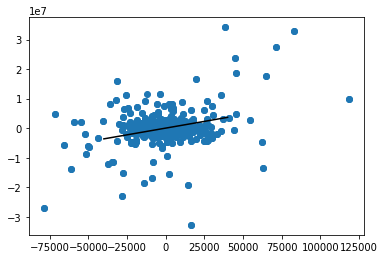

In [139]:
tup = (np.fft.fft(amount1[:15000]),np.fft.fft(gamma_power[:15000]))
slope, intercept, r, p, err = stats.linregress(*tup)

plt.scatter(*tup)
plt.plot(np.linspace(-40000,40000,100), intercept + slope * np.linspace(-40000,40000,100), '-', color = "black")

print("{0:1.2f}".format(int(r*100)/100))

=> Frequencies (fourier) correlate both unfiltered (0.3) and filtered (0.6)

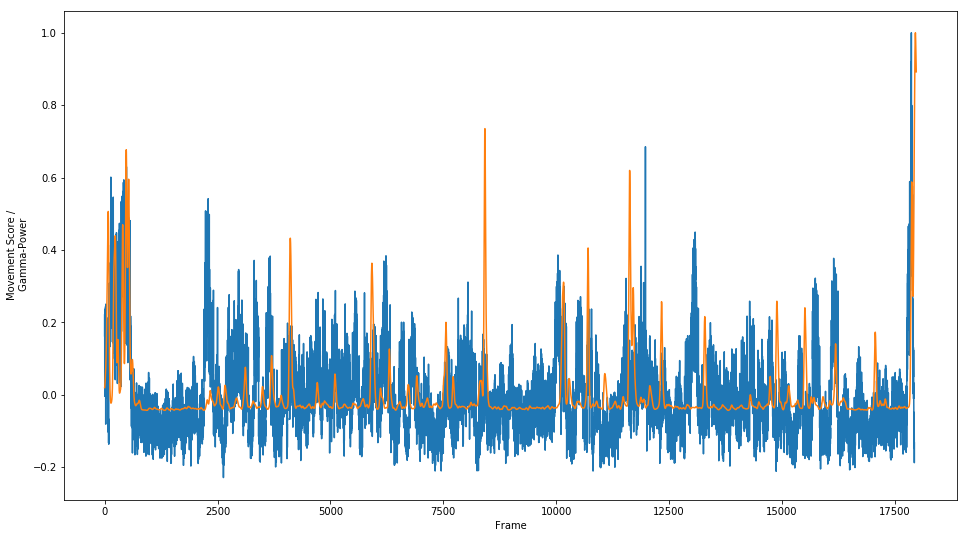

In [127]:
if(True): #Plot smoothed motion and gamma_power in time
    mot = amount1[2:-2]
    mot = mot-np.mean(mot)
    gam = gamma_power[:]
    gam = gam-np.mean(gam)

    fig, ax = plt.subplots(1,1,figsize =(16,9))
    plt.plot(gam/np.max(gam))
    plt.plot(mot/np.max(mot))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Movement Score /\n Gamma-Power")
    #plt.scatter(dataset[0],dataset[1])

In [103]:
from scipy import stats
corrs = []
snip = np.arange(-500,500)
for i in snip:
    slope, intercept, pearsons_r, p_value, std_err = stats.linregress(amount1[500+i:15000+i],gamma_power[500:15000])
    corrs.append(pearsons_r)

[[227]]


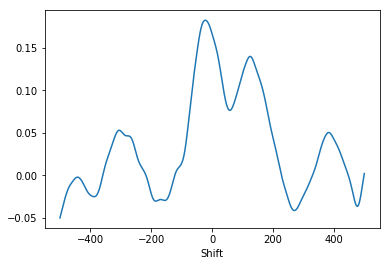

In [104]:
fig, ax = plt.subplots(1,1)
ax.plot(snip, corrs)
plt.xlabel('Shift', axes=ax)
print(np.argwhere(corrs==np.max(corrs))-250)

=> The correlation is clearly due to the correct timing of both signals and not and artifact
(One would expect a peak around 0 and it's actually there)

0.5290046281021435


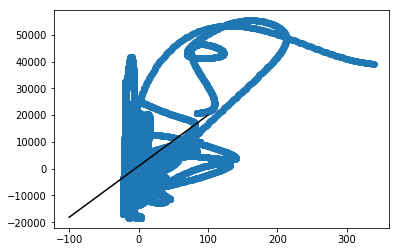

In [67]:
plt.scatter(amount1[:17930],gamma_power[:17930])
slope, intercept, pearsons_r, p_value, std_err = stats.linregress(amount1[100:15000],gamma_power[100:15000])
plt.plot(np.linspace(-100,100,100), intercept + slope * np.linspace(-100,100,100), '-', color = "black")
print(pearsons_r)


# Multiple linear regression

In [68]:
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import os
import json
from scipy import ndimage
import tables
import numpy as np
import statsmodels.api as sm

In [69]:
#A helper method for multiple regression
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [74]:
# define file pathes and LOAD EEGs and MOTION_TENSOR
path = "/mnt/c/Users/eler/Documents/Cognitive_Science/Bachelorarbeit/Scripts/processing_pipeline/dyad_13/DualEEG_RPS_C_13.eeg"
folder = "/mnt/c/Users/eler/Documents/Cognitive_Science/Bachelorarbeit/Scripts/processing_pipeline/dyad_13/"
h264_path = folder + "RPS_C_13_C3.hdf5"

h264 = tables.open_file(h264_path, mode='r')
h264 = h264.root.motion_tensor

eeg = load_eeg(path,6)#Here we define the files and channels to load
eeg1 = load_eeg(path,10)

In [75]:
# determine the correct output length and start time of video
idx = [x == "S128" for x in parse_vmrk(folder+"DualEEG_RPS_C_13.vmrk")['description']].index(True)
time = int(parse_vmrk(folder+"DualEEG_RPS_C_13.vmrk")['time'][idx])//20#20 datasamples for each frame
output_length = np.min([h264.shape[0]-time,eeg.shape[0]])

In [76]:
# load rois

rois = []
dataset = []

input_rois = []
input_rois.append('RPS_C_13_C3_left_head.json')
input_rois.append('RPS_C_13_C3_left_hands.json')
input_rois.append('RPS_C_13_C3_left_body.json')

for file_name in input_rois:
    with open(folder+file_name, encoding='utf-8') as fh:
        rois.append(json.load(fh))

In [77]:
# Obtain 1d movement signal for rois: Apply smoothing

for roi in rois:
    hist = weighted_histograms(h264, roi = roi)
    hist = ndimage.gaussian_filter(hist,0)
    amount = np.sum(hist,axis=0)#1d signal
    amount = amount - np.mean(amount)
    dataset.append(amount[:output_length])

0.0
0.0055617352614015575
0.011123470522803115
0.01668520578420467
0.02224694104560623
0.027808676307007785
0.03337041156840934
0.0389321468298109
0.04449388209121246
0.05005561735261402
0.05561735261401557
0.06117908787541713
0.06674082313681869
0.07230255839822025
0.0778642936596218
0.08342602892102335
0.08898776418242492
0.09454949944382647
0.10011123470522804
0.10567296996662959
0.11123470522803114
0.1167964404894327
0.12235817575083426
0.12791991101223582
0.13348164627363737
0.13904338153503892
0.1446051167964405
0.15016685205784205
0.1557285873192436
0.16129032258064516
0.1668520578420467
0.1724137931034483
0.17797552836484984
0.1835372636262514
0.18909899888765294
0.1946607341490545
0.20022246941045607
0.20578420467185762
0.21134593993325917
0.21690767519466073
0.22246941045606228
0.22803114571746386
0.2335928809788654
0.23915461624026696
0.2447163515016685
0.25027808676307006
0.25583982202447164
0.26140155728587317
0.26696329254727474
0.2725250278086763
0.27808676307007785
0.28

0.40044493882091214
0.40600667408231367
0.41156840934371525
0.41713014460511677
0.42269187986651835
0.42825361512791993
0.43381535038932145
0.43937708565072303
0.44493882091212456
0.45050055617352613
0.4560622914349277
0.46162402669632924
0.4671857619577308
0.4727474972191324
0.4783092324805339
0.4838709677419355
0.489432703003337
0.4949944382647386
0.5005561735261401
0.5061179087875417
0.5116796440489433
0.5172413793103449
0.5228031145717463
0.5283648498331479
0.5339265850945495
0.5394883203559511
0.5450500556173526
0.5506117908787542
0.5561735261401557
0.5617352614015573
0.5672969966629589
0.5728587319243604
0.578420467185762
0.5839822024471635
0.5895439377085651
0.5951056729699666
0.6006674082313682
0.6062291434927698
0.6117908787541713
0.6173526140155728
0.6229143492769744
0.628476084538376
0.6340378197997776
0.639599555061179
0.6451612903225806
0.6507230255839822
0.6562847608453838
0.6618464961067854
0.6674082313681868
0.6729699666295884
0.67853170189099
0.6840934371523916
0.68965

.........

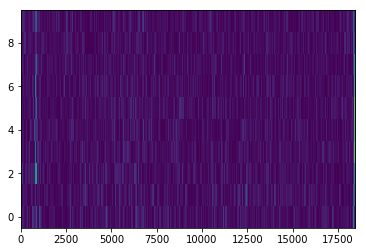

In [107]:
if(True):#inspect frequency diagram: You dont always see something here
    plt.imshow(np.abs(spectrogram(eeg-eeg1,f_min=30,f_max=40))[:2000],aspect="auto", origin="lower")

In [80]:
#Calculate gamma power: Aplly smoothing
spectrum = np.abs(spectrogram(eeg-eeg1, f_min=30,f_max=50))
gamma = np.sum(spectrum, axis = 0)
gamma = gamma[time:]

dataset.append(gamma[:output_length])
dataset.append(gamma[:output_length])
dataset = np.array(dataset)

.........

In [81]:
dataset[:-1].shape

(4, 17465)

In [85]:
if(True):#Smoothing
    for i in range(len(dataset[:-2])):
        dataset[i] = ndimage.filters.gaussian_filter1d(dataset[i],50)
        #mot = ndimage.filters.gaussian_filter1d(mot,75)
if(True):   
    dataset[-1] = ndimage.filters.gaussian_filter1d(dataset[-1],50)
    #dataset[-1] = ndimage.filters.gaussian_filter1d(dataset[-1],50)


In [86]:
original_order = np.copy(dataset)

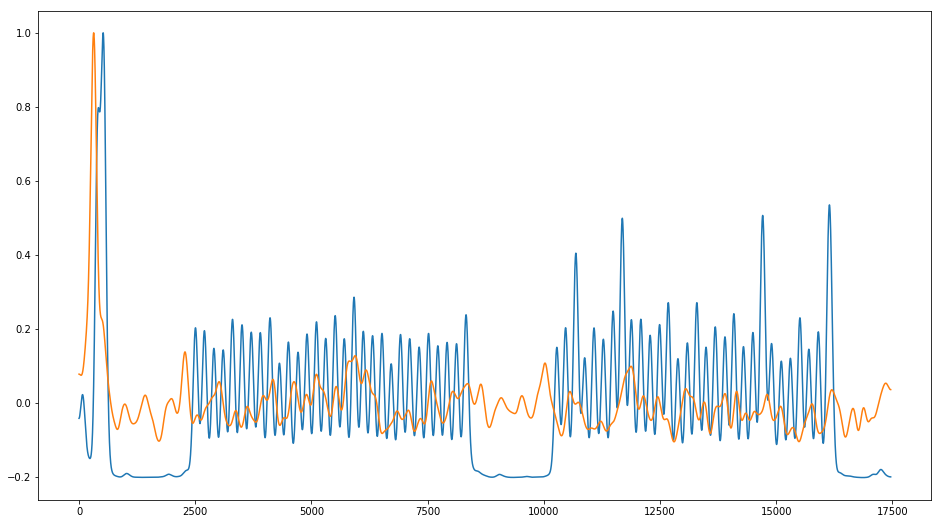

In [87]:
if(True): #Plot smoothed motion and gamma_power in time
    mot = dataset[1]
    mot = mot-np.mean(mot)
    gam = dataset[-1]
    gam = gam-np.mean(gam)

    fig, ax = plt.subplots(1,1,figsize =(16,9))
    plt.plot(mot/np.max(mot))
    plt.plot(gam/np.max(gam))
    #plt.scatter(dataset[0],dataset[1])

In [88]:
# shuffle dataset
order = np.random.permutation(output_length)
np.take(dataset,order,axis = 1, out = dataset)

array([[-1.75613992e+01, -2.04134712e+01, -1.96696517e+01, ...,
        -2.05303812e+01,  2.94357422e+00, -7.17985726e+00],
       [ 1.73574034e+01, -8.04794158e+01, -8.17361659e+01, ...,
        -8.20557393e+01,  3.35504983e+01, -6.90314437e+01],
       [-8.15092606e+00, -3.11161962e+01, -3.19916494e+01, ...,
        -3.59800211e+01,  1.62397282e+01, -1.65110213e+01],
       [ 3.94140124e+04,  4.23480698e+04,  3.11437659e+04, ...,
         3.72105110e+04,  4.59981130e+04,  3.38786949e+04],
       [ 3.69159040e+04,  4.50446610e+04,  3.54739807e+04, ...,
         4.00872780e+04,  4.62348132e+04,  4.36028814e+04]])

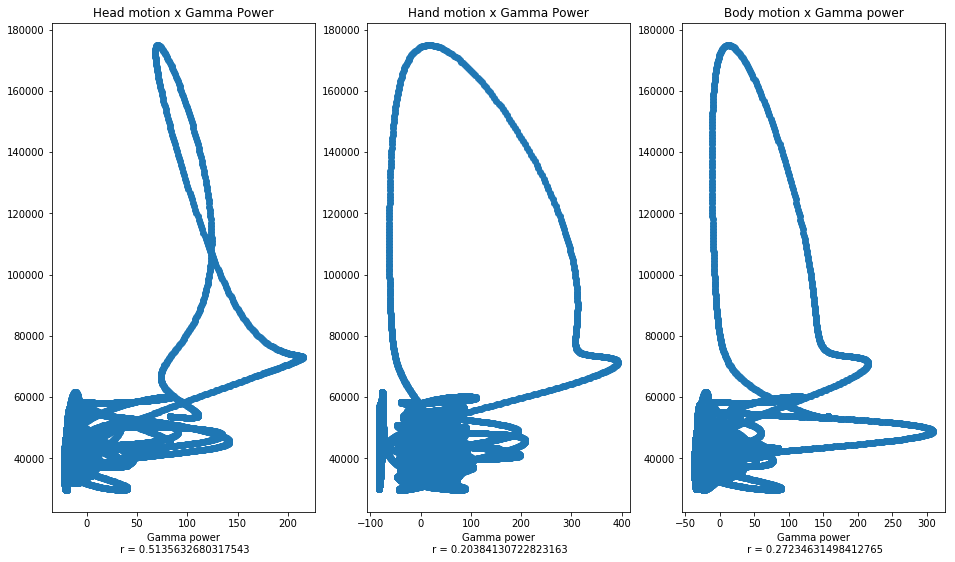

In [89]:
if(True): #
    fig, ax = plt.subplots(1,3,figsize =(16,9))

    titles = ["Head motion x Gamma Power","Hand motion x Gamma Power", "Body motion x Gamma power"]
    y_labels = ["Gamma power" for x in range(3)]
    x_labels = ["Head Motion Index","Hand Motion Index","Body Motion Index"]

    for i, title, x_label, y_label in zip(range(3),titles,x_labels,y_labels):
        tup = (dataset[i],dataset[-1])#0 for head, 2 for hands, 3 for body
        ax[i].scatter(*tup)
        ax[i].set_title(title)
        pearsons_r = stats.linregress(*tup)[2]
        pearsons_r = str("{}".format(pearsons_r))
        ax[i].set_xlabel(y_label + "\n r = " + pearsons_r)

In [90]:
y = dataset[-1][:-3500]
x = dataset[0:3][:,:-3500]

x_test = dataset[0:3][:,-3500:]
y_test = dataset[-1][-3500:]

y_test_unfiltered = dataset[-2][-3500:]

In [91]:
x_test = np.insert(np.swapaxes(x_test,0,1),0,1,axis=1)

In [92]:
model = reg_m(y, x)

In [486]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     1965.
Date:                Wed, 23 Jan 2019   Prob (F-statistic):               0.00
Time:                        06:10:36   Log-Likelihood:            -1.6502e+05
No. Observations:               13964   AIC:                         3.301e+05
Df Residuals:                   13960   BIC:                         3.301e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           534.6818     15.734     33.982      0.0

In [487]:
print("{}".format(list(model._results.params)))

[534.6818038295536, -3500.2933087798096, 32.4221183860578, 168355.6805321851]


In [488]:
model._results.params

array([ 5.34681804e+02, -3.50029331e+03,  3.24221184e+01,  1.68355681e+05])

In [489]:
pred = model.predict(x_test)

0.0647020258207943
0.00012789868000070794
3.788772691880675e-05


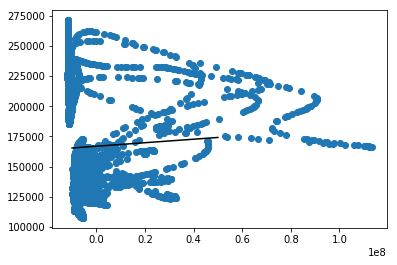

In [490]:
tup = (pred[:],y_test[:])
plt.scatter(*tup)
slope, intercept, r, p, err = stats.linregress(*tup)
x_vals = np.linspace(-10000000,50000000,10)
plt.plot(x_vals, intercept + slope * x_vals, '-', color = "black")

print(r)
print(p)
print(err)

0.04669896770098806
0.005722560830253477
4.846404373211286e-05


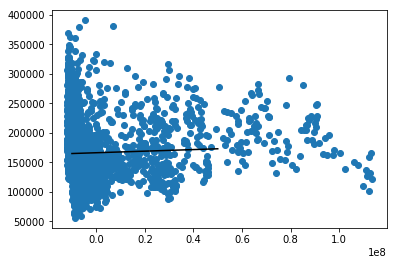

In [491]:
tup = (pred[:],y_test_unfiltered[:])
plt.scatter(*tup)
slope, intercept, r, p, err = stats.linregress(*tup)
x_vals = np.linspace(-10000000,50000000,10)
plt.plot(x_vals, intercept + slope * x_vals, '-', color = "black")

print(r)
print(p)
print(err)

=> The model explains also the original (unfiltered) EEG as the high correlation indicates (Smothed movement data was used)

In [236]:
original_movement = np.insert(np.swapaxes(original_order[0:3],0,1),0,.291,axis=1)
original_eeg = original_order[0]

In [146]:
pred1 = model.predict(original_movement)

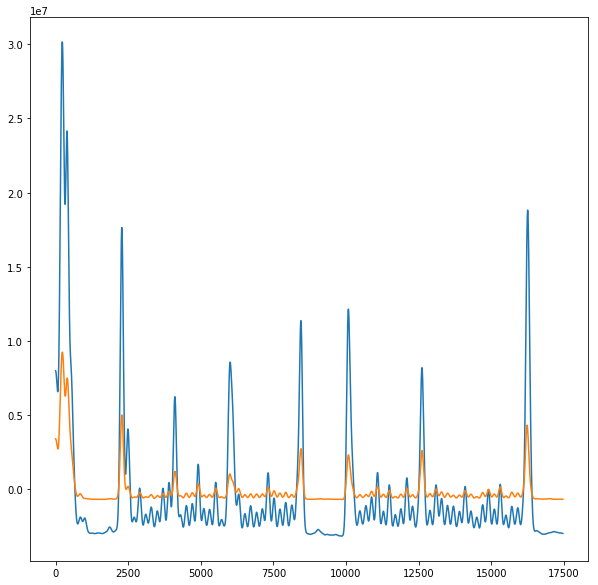

In [147]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.plot(pred1)
plt.plot(original_eeg*10000)

In [148]:
np.min(original_eeg+70)

1.1400536858826769

# Correlations between EEG and Motion for contrasts between all electrodes

In [497]:
movement_signals = original_order[:-1]

In [498]:
mov_length = movement_signals[0].shape[0]

In [500]:
correlations = []
for roi in range(1):#head hands body
    correlation_coefficients = np.zeros(shape=(32,32), dtype = np.float32)
    ps = np.zeros(shape=(32,32), dtype = np.float32)

    for i in range(32):
        print(str(i) + "-----------")
        for j in range(32-i-1):
            print("")
            contrast = load_eeg(path,i)-load_eeg(path,j)
            spectrum = np.abs(spectrogram(contrast, f_min=30,f_max=50))
            gamma = np.sum(spectrum, axis = 0)
            gamma = gamma[time:]
            
            gamma = gamma[:mov_length]#cut it down to correct size again
            
            if(True):#Smoothing
                gamma = ndimage.filters.gaussian_filter1d(gamma,50)
                gamma = ndimage.filters.gaussian_filter1d(gamma,50)

            slope, intercept, r, p, err = stats.linregress(gamma,movement_signals[roi])
            correlation_coefficients[i][j] = r
            ps[i][j] = p
    correlations.append(correlation_coefficients)
    correlations.append(ps)

0-----------
.........

/home/gerstenberger/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:115: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/gerstenberger/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:127: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


..............................................................................................................................................................................................................................................................................1-----------
..............................................................................................................................................................................................................................................................................2-----------
.....................................................................................................................................................................................................................................................................3-----------
................................................................................................................................................................

/home/gerstenberger/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


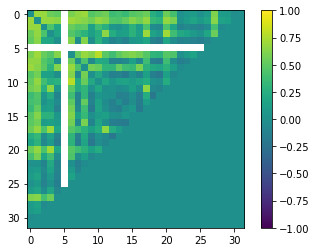

In [523]:
fig, ax = plt.subplots(1)
im = ax.imshow(np.ma.masked_where(correlations[0]<-10,correlations[0]),vmin=-1,vmax=1)
plt.colorbar(im)

In [513]:
import pickle
with open("correlations", "wb") as f:
    pickle.dump(correlations,f)

In [516]:
correlations = []
with open("correlations", "rb") as f:
    correlations = pickle.load(f)

In [ ]:
np.ma.masked_where(correlations[2]<0.3,correlations[2])

# Behavioral synchrony

In [43]:
h264_path = folder + "RPS_C_13_C1.hdf5"

h264 = tables.open_file(h264_path, mode='r')
h264 = h264.root.motion_tensor


rois = []

input_rois = []
input_rois.append('RPS_C_13_C3_left_head.json')
input_rois.append('RPS_C_13_C3_left_hands.json')
input_rois.append('RPS_C_13_C3_left_body.json')

input_rois.append('RPS_C_13_C3_right_head.json')
input_rois.append('RPS_C_13_C3_right_hands.json')
input_rois.append('RPS_C_13_C3_right_body.json')

for file_name in input_rois:
    with open(folder+file_name, encoding='utf-8') as fh:
        rois.append(json.load(fh))

In [48]:
motion = []
for roi in rois:
    hist = weighted_histograms(h264, roi = roi)
    hist = ndimage.gaussian_filter(hist,0)
    amount = np.sum(hist,axis=0)#1d signal
    amount = amount - np.mean(amount)
    motion.append(amount[:output_length])

0.0
0.005562044607597753
0.011124089215195506
0.01668613382279326
0.02224817843039101
0.027810223037988763
0.03337226764558652
0.03893431225318427
0.04449635686078202
0.050058401468379775
0.05562044607597753
0.06118249068357528
0.06674453529117304
0.07230657989877079
0.07786862450636854
0.0834306691139663
0.08899271372156405
0.0945547583291618
0.10011680293675955
0.1056788475443573
0.11124089215195505
0.1168029367595528
0.12236498136715056
0.1279270259747483
0.13348907058234608
0.1390511151899438
0.14461315979754158
0.15017520440513932
0.15573724901273708
0.16129929362033482
0.1668613382279326
0.17242338283553035
0.1779854274431281
0.18354747205072586
0.1891095166583236
0.19467156126592136
0.2002336058735191
0.20579565048111687
0.2113576950887146
0.21691973969631237
0.2224817843039101
0.22804382891150787
0.2336058735191056
0.23916791812670338
0.24472996273430112
0.2502920073418989
0.2558540519494966
0.2614160965570944
0.26697814116469215
0.2725401857722899
0.2781022303798876
0.28366427

0.40602925635463594
0.41159130096223373
0.41715334556983147
0.4227153901774292
0.428277434785027
0.43383947939262474
0.4394015240002225
0.4449635686078202
0.450525613215418
0.45608765782301575
0.4616497024306135
0.4672117470382112
0.472773791645809
0.47833583625340675
0.4838978808610045
0.48945992546860223
0.4950219700762
0.5005840146837978
0.5061460592913956
0.5117081038989932
0.517270148506591
0.5228321931141888
0.5283942377217865
0.5339562823293843
0.539518326936982
0.5450803715445798
0.5506424161521776
0.5562044607597753
0.561766505367373
0.5673285499749708
0.5728905945825685
0.5784526391901663
0.5840146837977641
0.5895767284053618
0.5951387730129596
0.6007008176205573
0.6062628622281551
0.6118249068357529
0.6173869514433505
0.6229489960509483
0.6285110406585461
0.6340730852661438
0.6396351298737416
0.6451971744813393
0.6507592190889371
0.6563212636965349
0.6618833083041326
0.6674453529117303
0.6730073975193281
0.6785694421269258
0.6841314867345236
0.6896935313421214
0.695255575949

0.8343066911396629
0.8398687357472607
0.8454307803548584
0.8509928249624562
0.856554869570054
0.8621169141776517
0.8676789587852495
0.8732410033928472
0.878803048000445
0.8843650926080427
0.8899271372156404
0.8954891818232382
0.901051226430836
0.9066132710384337
0.9121753156460315
0.9177373602536293
0.923299404861227
0.9288614494688248
0.9344234940764224
0.9399855386840202
0.945547583291618
0.9511096278992157
0.9566716725068135
0.9622337171144113
0.967795761722009
0.9733578063296068
0.9789198509372045
0.9844818955448023
0.9900439401524
0.9956059847599977
0.0
0.005562044607597753
0.011124089215195506
0.01668613382279326
0.02224817843039101
0.027810223037988763
0.03337226764558652
0.03893431225318427
0.04449635686078202
0.050058401468379775
0.05562044607597753
0.06118249068357528
0.06674453529117304
0.07230657989877079
0.07786862450636854
0.0834306691139663
0.08899271372156405
0.0945547583291618
0.10011680293675955
0.1056788475443573
0.11124089215195505
0.1168029367595528
0.1223649813671

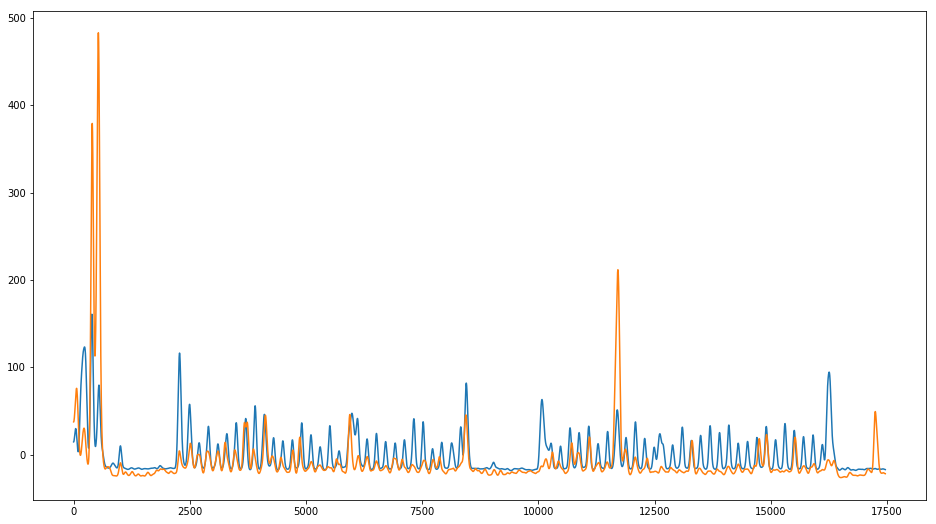

In [76]:
if(True):
    tup = (ndimage.gaussian_filter(motion[1],25),ndimage.gaussian_filter(motion[4],25))

    mot1 = motion[1]
    #mot1 = mot1-np.mean(mot1)
    #mot1 = mot1/np.max(mot1)
    
    mot2 = motion[4]
    #mot2 = mot2-np.mean(mot2)
    #mot2 = mot2/np.max(mot2)

    fig, ax = plt.subplots(1,1,figsize =(16,9))
    plt.plot(tup[0])
    plt.plot(tup[1])


0.5138554222887679
0.8854129281483425


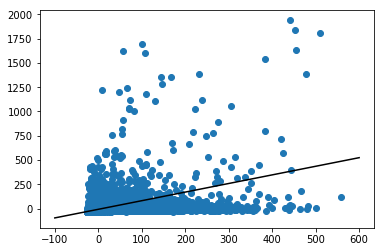

In [86]:
from scipy import stats


tup = (ndimage.gaussian_filter(motion[1],25),ndimage.gaussian_filter(motion[4],25))
slope, intercept, r, p, err = stats.linregress(*tup)

plt.scatter(motion[1],motion[4])
plt.plot(np.linspace(-100,600,100), intercept + slope * np.linspace(-100,600,100), '-', color = "black")
print(r)
print(slope)

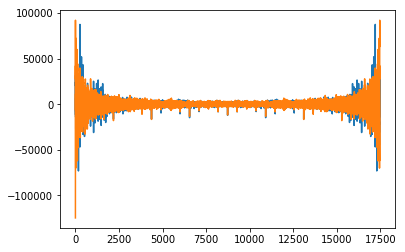

In [90]:
plt.plot(np.fft.fft(motion[1]).real)
plt.plot(np.fft.fft(motion[4]).real)

0.30815256705288296


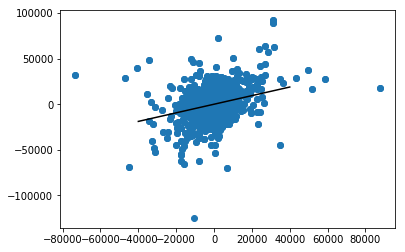

In [94]:
tup = (np.fft.fft(motion[1]).real,np.fft.fft(motion[4]).real)
plt.scatter(*tup)

slope, intercept, r, p, err = stats.linregress(*tup)
plt.plot(np.linspace(-40000,40000,100), intercept + slope * np.linspace(-40000,40000,100), '-', color = "black")
print(r)

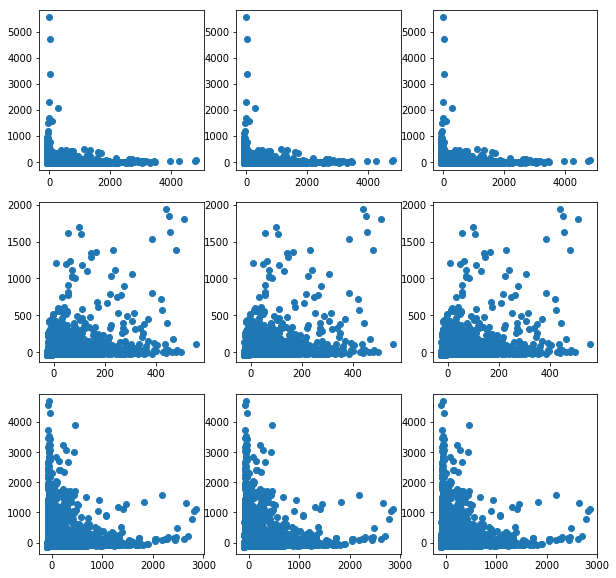

In [518]:
from scipy import stats

fig = plt.figure(figsize=(10,10))

p1 = motion[:3]
p2 = motion[3:]

axes = []

i = 1
for y in range(1,4):
    for x in range(1,4):
        ax = fig.add_subplot(3,3,i)
        ax.scatter(p1[y-1],p2[y-1])
        axes.append(ax)
        
        i += 1

# Simple sample case

In [ ]:
half = 10000
labels = dataset[-1]
data = dataset[0]

results = sm.OLS(labels[:half], data[:half]).fit()
predictions = results.predict(data[half:])

In [ ]:
import statsmodels.api as sm

y=[1,2,3,4,5,6,7,8,9,10]
x=[2,4,6,8,10,12,14,16,18,20]
model=sm.OLS(y,sm.add_constant(x)).fit()

print([model._results.params])

c=200
print (model.predict([[0,1]]))

# Computing the envelope

In [ ]:
from scipy.signal import hilbert

In [ ]:
envelope = np.abs(hilbert(np.sum(ndimage.gaussian_filter(display,2),axis=0)))

In [ ]:
plt.plot(ndimage.gaussian_filter(envelope,20))
#plt.plot(np.sum(ndimage.gaussian_filter(display,0),axis=0))

# Computing Frequency bands

In [ ]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------f
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [ ]:
eeg = load_eeg(path, 0)

In [ ]:
bandpower(eeg[0:2000],2000,[7,13],1)

In [ ]:
def power_density(eeg, bandpower_function, freq = [7,13], window_size =2000,step_size = 20):
    output_size = len(eeg)//step_size
    power = np.zeros(output_size)

    for i in range(len(power)):
        snippet = eeg[step_size*i-window_size//2:step_size*i+window_size//2]
        if not len(snippet == window_size):
            continue
        val = bandpower_function(snippet,2000,freq)
        power[i] = val

        if i % 2000 == 0:
            print(".", end ="")
    return power

In [ ]:
window_size = 2000
step_size = 10
freq = [7,13]

In [ ]:
output_size = len(eeg)//step_size

In [ ]:
alpha_power = np.zeros(output_size)

In [ ]:
for i in range(0,len(alpha_power),step_size):
    snippet = eeg[i-window_size//2:i+window_size//2]
    if not len(snippet == window_size):
        continue
    val = bandpower(snippet,2000,freq)
    alpha_power[i] = val
    
    if i % 2000 == 0:
        print(".", end ="")

In [ ]:
plt.plot(alpha_power[:])

In [ ]:
%matplotlib inline
plt.plot(power_density(load_eeg(path,0), bandpower, freq = [100,200]))


In [ ]:
import mne

In [ ]:
data = []
for i in range(32):
    data.append(load_eeg(path,i))

In [ ]:
data = np.array(data)

In [ ]:
data[i,:].shape

In [ ]:
alpha_powers = []
for i in range(32):
    print("|", end ="")
    alpha_powers.append(power_density(data[i,:], bandpower, freq = [7,14]))
    

In [ ]:
alpha_powers = np.array(alpha_powers)

In [ ]:
gamma_power = []
for i in range(32):
    print("|", end ="")
    gamma_power.append(power_density(data[i,:], bandpower, freq = [32,100]))

In [ ]:
gamma_power = np.array(gamma_power)

In [ ]:
gamma_power[:,0]

In [ ]:
import scipy.io
mat = scipy.io.loadmat('easycapM23.mat')

In [ ]:
mne.viz.plot_topomap(alpha_powers[:,1002],mat["lay"]["pos"][0][0][0:32])

In [ ]:
labels = [str(mat["lay"]['label'][0][0][:,0][i][0]) for i in range(len(mat["lay"]['label'][0][0][:,0]))]

In [ ]:
%matplotlib notebook

In [ ]:
import matplotlib.animation

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
mne.viz.plot_topomap(alpha_powers[:,0],mat["lay"]["pos"][0][0][0:32], axes = ax)

skip_factor = 100
start_pos = 0
frames = 160

def animate(i):
    pos = i*skip_factor + start_pos
    ax.cla()
    mne.viz.plot_topomap(alpha_powers[:,pos],mat["lay"]["pos"][0][0][0:32], axes = ax)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames)

    
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(20,10))
for i in range(32):
    ax.plot(alpha_powers[0,:])

In [ ]:
np.nanmean(alpha_powers)

In [ ]:
print(__doc__)


# Code source: Jaques Grobler
# License: BSD 3 clause


import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
import numpy as np
import statsmodels.api as sm

y = [1,2,3,4,3,4,5,4,5,5,4,5,4,5,4,5,6,5,4,5,4,3,4]

x = [
     [4,2,3,4,5,4,5,6,7,4,8,9,8,8,6,6,5,5,5,5,5,5,5],
     [4,1,2,3,4,5,6,7,5,8,7,8,7,8,7,8,7,7,7,7,7,6,5],
     [4,1,2,5,6,7,8,9,7,8,7,8,7,7,7,7,7,7,6,6,4,4,4]
     ]

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [ ]:
print(reg_m(y, x).summary())